Time series anomaly detection using an LSTM autoencoder, licensed under the Apache License, Version 2.0<br>
http://www.apache.org/licenses/LICENSE-2.0

# General libraries

In [1]:
# Importing the numpy library (for arrays operations)
# Importing the pandas library (for data analysis)
# Importing the matplotlib.pyplot interface (for MATLAB-like plots)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset preparation
We retrieve the share prices of the mutual fund "PIMCO Fixed Income SHares: Series M" (FXIMX) between 2000-10-18 and 2022-05-20 ("FXIMX.csv") from finance.yahoo.com:<br>
https://finance.yahoo.com/quote/FXIMX/history

In [26]:
# Storing the "Date" and "Close" price of the csv file in DataFrame "df"
# Setting to datetime format the "Date" column and removing hours, minutes and seconds

df = pd.read_csv('FXIMX.csv', usecols=['Date', 'Close'])
df['Date'] = pd.to_datetime(df['Date']).dt.date
df

,Date,Close
0,2000-10-18,10.46
1,2000-10-19,10.49
2,2000-10-20,10.51
3,2000-10-23,10.55
4,2000-10-24,10.54
...,...,...
5427,2022-05-16,9.16
5428,2022-05-17,9.11
5429,2022-05-18,9.14
5430,2022-05-19,9.15


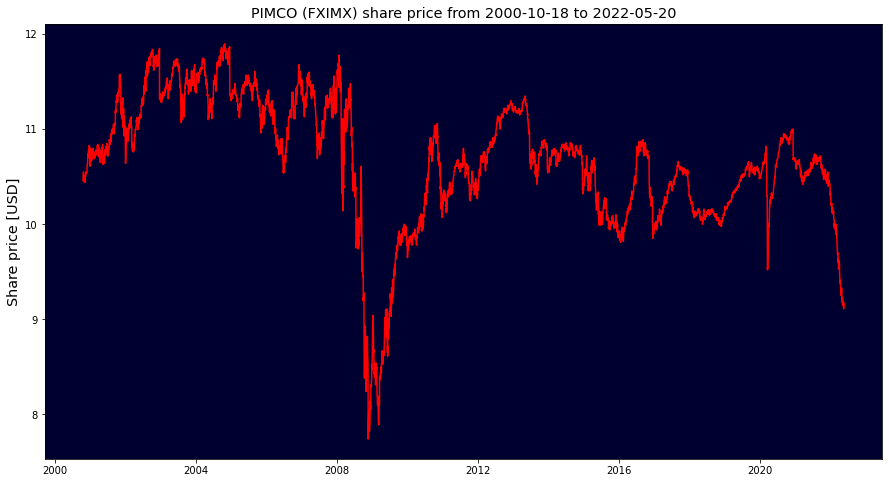

In [3]:
# Plot of PIMCO (FXIMX) share prices

_, price = plt.subplots(figsize=(15,8))

price.plot(df['Date'], df['Close'], color='r')

# Parameters of the plot

price.set_title('PIMCO (FXIMX) share price from %s to %s' % (df['Date'].min(), df['Date'].max()), size='x-large')
price.set_ylabel('Share price [USD]', size='x-large')
price.set_facecolor('#000030')

plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.show()

In [4]:
# Setting a separation date to distinguish traning and test sets, with arrays "train_arr" and "test_arr"
# Storing in a list "test_dates" the dates corresponding to "test_arr"

separation = pd.to_datetime('2020-01-01').date()

train_arr = (df.loc[df['Date'] <= separation]['Close']).values
train_arr = train_arr.reshape(-1, 1)

test_arr = (df.loc[df['Date'] > separation]['Close']).values
test_arr = test_arr.reshape(-1, 1)

train_dates = (df.loc[df['Date'] <= separation]['Date']).values
test_dates = (df.loc[df['Date'] > separation]['Date']).values

train_arr.shape, len(train_dates), test_arr.shape, len(test_dates)

((4830, 1), 4830, (602, 1), 602)

We import the estimator "StandardScaler" from the sklearn.preprocessing module to rescale the data by removing the mean and scaling to unit variance<br>
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler

We rescale with StandardScaler the training data and, in order to avoid any data leakage and look-ahead bias, we use the same scaling parameters to rescale the test data.<br>
https://en.wikipedia.org/wiki/Leakage_(machine_learning)<br>
https://www.investopedia.com/terms/l/lookaheadbias.asp

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_arr = scaler.fit_transform(train_arr)
test_arr = scaler.transform(test_arr)

We define a function "create_sequences" which creates two numpy arrays "sequences" and "labels" given an input array "arr" and a number of time steps "n". The 1D numpy array labels contains all the last values of arr, starting from the n-th value. The 2D numpy array sequences contains all the sequences of n consecutive values of arr.

In [6]:
def create_sequences(arr, n):
    sequences, labels = [], []
    for i in range(n, arr.shape[0]+1):
        sequences.append(arr[i-n: i, 0])
        labels.append(arr[i-1, 0])
    return np.array(sequences), np.array(labels)

In [7]:
# Setting a number of time steps in "timesteps"
# Using the function create_sequences to create the training and test arrays for the model
# Storing in "train_dates" and "test_dates" the list of dates corresponding to train_labels and test_labels

timesteps = 30
train_seqs, train_labels = create_sequences(train_arr, timesteps)
test_seqs, test_labels = create_sequences(test_arr, timesteps)
train_dates = train_dates[timesteps-1:]
test_dates = test_dates[timesteps-1:]

train_seqs.shape, train_labels.shape, len(train_dates), test_seqs.shape, test_labels.shape, len(test_dates)

((4801, 30), (4801,), 4801, (573, 30), (573,), 573)

In [8]:
# Reshaping train_seqs and test_seqs into the 3D array needed for the LSTM input layer of the autoencoder
# The 3D array includes: number of samples, number of time steps and number of features (here 1 for "Close" values)

train_seqs = np.reshape(train_seqs, (train_seqs.shape[0], train_seqs.shape[1], 1))
test_seqs = np.reshape(test_seqs, (test_seqs.shape[0], test_seqs.shape[1], 1))

train_seqs.shape, test_seqs.shape

((4801, 30, 1), (573, 30, 1))

# LSTM autoencoder
We start by importing some classes from Keras:

- the "Sequential" class from the keras.models API (to group a linear stack of layers into a model)
- the "LSTM" class from the keras.layers API (to apply a long short-term memory layer to an input)
- the "RepeatVector" class from the keras.layers API (to repeat an input various times)
- the "TimeDistributed" class from the keras.layers API (to apply a layer to every temporal slice of an input)
- the "Dense" class from the keras.layers API (to apply a regular densely-connected NN layer to an input)

See https://keras.io/api/models and https://keras.io/api/layers.

In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense

We define a LSTM autoencoder which takes as input the 3D array with format

$$
\hbox{samples}~\times~\hbox{time steps}~\times~\hbox{features}
=\hbox{train_seqs.shape[0]}\times\hbox{train_seqs.shape[1]}\times\hbox{train_seqs.shape[2]}
$$

and returns as output the encoded-and-decoded data of the same format.

- Layer 1, LSTM(2·units_ℓ), reads the input data and outputs a 2D array of size train_seqs.shape[2] x 2·units_ℓ due to option return_sequences=True.
- Layer 2, LSTM(units_ℓ), reads the train_seqs.shape[2] x 2·units_ℓ output from layer 1 and reduces the feature size to units_ℓ. Since return_sequences=False, it outputs a feature vector of size 1 x units_ℓ, namely, the encoded feature vector of the input data.
- Layer 3, RepeatVector(train_seqs.shape[1]), replicates the feature vector train_seqs.shape[1] (= time steps) times. The RepeatVector layer acts as a bridge between the encoder and decoder modules. It prepares the 2D array input for the first LSTM layer of the decoder. The decoder module is designed to unfold the encoding, and thus has layers stacked in the reverse order of the encoder.
- Layers 4 and 5, LSTM(units_ℓ) and LSTM(2·units_ℓ), are the mirror images of layers 2 and 1, respectively.
- Layer 6, TimeDistributed(Dense(train_seqs.shape[2])), creates a vector of length equal to the number of features outputted by the previous layer. Since layer 5 outputs 2·units_ℓ features, the TimeDistributed layer creates a vector of size 2·units_ℓ x 1 and replicates it train_seqs.shape[2] (= features) time. The output of layer 5 is a train_seqs.shape[1] x 2·units_ℓ array that we denote by U and that of layer 6 is a 2·units_ℓ x train_seqs.shape[2] array that we denote by V, so that a matrix multiplication between U and V yields a train_seqs.shape[1] x train_seqs.shape[2] array.

See the following blog for nice diagrams of the LSTM autoencoder layers:<br>
https://towardsdatascience.com/step-by-step-understanding-lstm-autoencoder-layers-ffab055b6352

In [10]:
units_ℓ = 64

model = Sequential()
model.add(LSTM(2*units_ℓ, input_shape=(train_seqs.shape[1], train_seqs.shape[2]), return_sequences=True))
model.add(LSTM(units_ℓ))
model.add(RepeatVector(train_seqs.shape[1]))
model.add(LSTM(units_ℓ, return_sequences=True))
model.add(LSTM(2*units_ℓ, return_sequences=True))
model.add(TimeDistributed(Dense(train_seqs.shape[2])))

We give a summary of the model using the "summary" method of the model class of Keras. The "None" value stands for the (not yet defined) value of the batch size.<br>
https://keras.io/api/models/model/#summary-method

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVector  (None, 30, 64)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 30, 128)           98816     
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            129       
 ibuted)                                                

We import the "plot_model" function from the "keras.utils.vis_utils" module to plot a schema of the model.<br>
https://keras.io/api/utils/model_plotting_utils

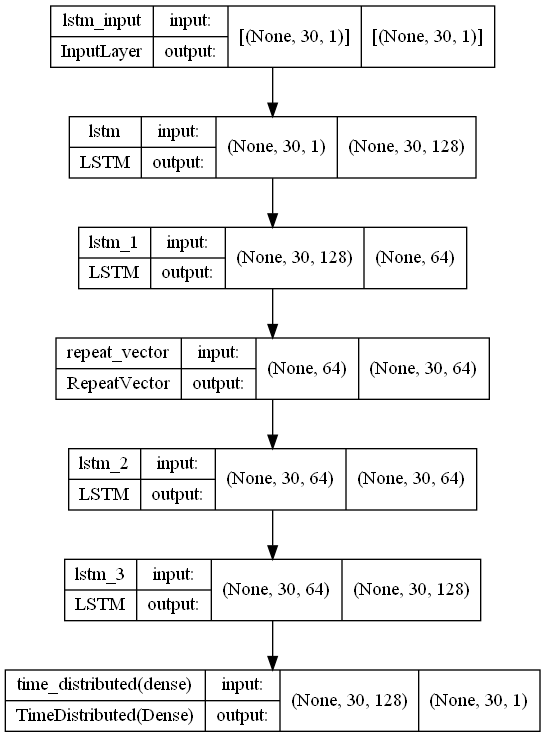

In [12]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True)

We configure (compile) the model for training with the following parameters:

- mean square error (mse) between labels and predictions as quantity to minimise during training process
- root mean absolute error between labels and predictions as metric to display during training process
- "adam" as optimizer to use during training process (a combination of gradient descent with momentum and RMSP)<br>
https://keras.io/api/optimizers/adam

In [13]:
model.compile(loss='mse', optimizer='adam', metrics='RootMeanSquaredError')

We train the model with a given input array, output array, batch size and number of epochs.<br>
https://keras.io/api/models/model_training_apis/#fit-method

An epoch is a pass of the neural network over the entire training set and the batch size is the number of samples that are passed to the network at once (the default batch size in Keras is 32). For each epoch, we thus have

$$
\hbox{number of training steps} = \frac{\hbox{length of training set}}{\hbox{batch size}}\;\!.
$$

In [14]:
# Training the model and saving the model's attributes in the HDF5 file "model_parameters.h5"
# See https://en.wikipedia.org/wiki/Hierarchical_Data_Format

batch_size = 2
epochs = 30
history = model.fit(train_seqs, train_seqs, batch_size=batch_size, epochs=epochs)
model.save('model_parameters.h5')

Epoch 1/30
2401/2401 [==============================] - 85s 34ms/step - loss: 0.0673 - root_mean_squared_error: 0.2594
Epoch 2/30
2401/2401 [==============================] - 100s 42ms/step - loss: 0.0402 - root_mean_squared_error: 0.2004
Epoch 3/30
2401/2401 [==============================] - 93s 39ms/step - loss: 0.0353 - root_mean_squared_error: 0.1880
Epoch 4/30
2401/2401 [==============================] - 97s 40ms/step - loss: 0.0267 - root_mean_squared_error: 0.1633
Epoch 5/30
2401/2401 [==============================] - 98s 41ms/step - loss: 0.0286 - root_mean_squared_error: 0.1692
Epoch 6/30
2401/2401 [==============================] - 97s 40ms/step - loss: 0.0202 - root_mean_squared_error: 0.1420
Epoch 7/30
2401/2401 [==============================] - 99s 41ms/step - loss: 0.0200 - root_mean_squared_error: 0.1415
Epoch 8/30
2401/2401 [==============================] - 94s 39ms/step - loss: 0.0141 - root_mean_squared_error: 0.1185
Epoch 9/30
2401/2401 [=========================

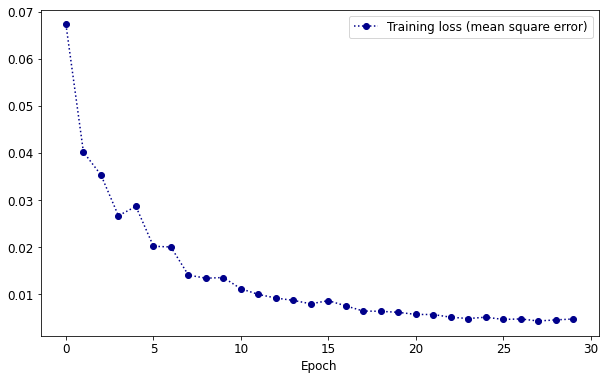

In [15]:
# Plot of the training loss (mean square error)

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], color='darkblue', linestyle='dotted', marker='o', label='Training loss (mean square error)')

# Parameters of the plot

plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.xlabel('Epoch', size='large')
plt.legend(fontsize='large')
plt.show()

# Reconstruction of training data and test data
We check the precision of the autoencoder by plotting its reconstruction of the traning data and the test data vs. the original traning data and test data. We start with the training data.

In [16]:
# Importing "load_model" function from the keras.models API (to load a model saved via model.save())
# Storing in numpy array "train_reconstructed" the training share prices reconstructed by the autoencoder
# Storing in numpy array "train_original" the original share prices contained in "train_labels"
# Putting back both arrays to the original scale and format

from keras.models import load_model

model = load_model('model_parameters.h5')

train_reconstructed = model.predict(train_seqs)
train_reconstructed = scaler.inverse_transform(train_reconstructed[:, timesteps-1])
train_original = scaler.inverse_transform(train_labels.reshape(-1, 1))

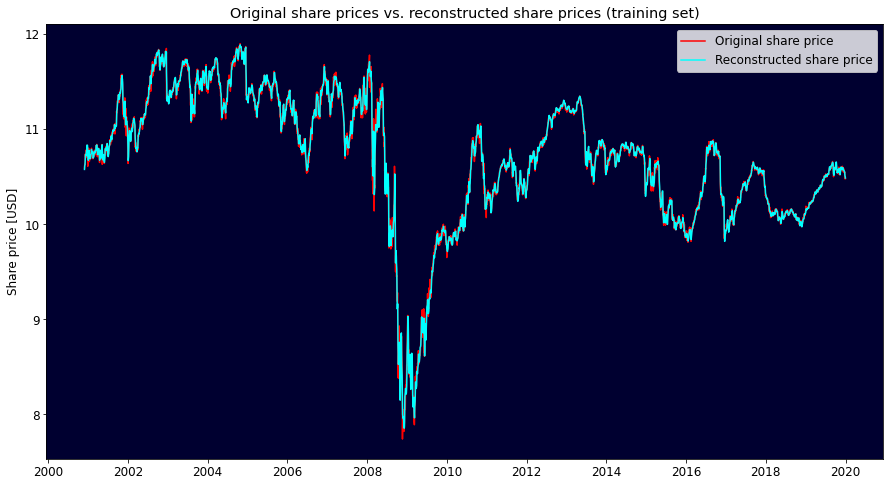

In [17]:
# Plot of original share prices vs. reconstructed share prices for the training set

_, p_train = plt.subplots(figsize=(15,8))

p_train.plot(train_dates, train_original, color='r', label='Original share price')
p_train.plot(train_dates, train_reconstructed, color='cyan', label='Reconstructed share price')

# Parameters of the plot

p_train.set_title('Original share prices vs. reconstructed share prices (training set)', size='x-large')
p_train.set_ylabel('Share price [USD]', size='large')
p_train.set_facecolor('#000030')
p_train.legend(fontsize='large')

plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.show()

We now plot the reconstruction of the test data.

In [18]:
# Storing in numpy array "test_reconstructed" the test share prices reconstructed by the autoencoder
# Storing in numpy array "test_original" the original share prices contained in "test_labels"
# Putting back both arrays to the original scale and format

test_reconstructed = model.predict(test_seqs)
test_reconstructed = scaler.inverse_transform(test_reconstructed[:, timesteps-1])
test_original = scaler.inverse_transform(test_labels.reshape(-1, 1))

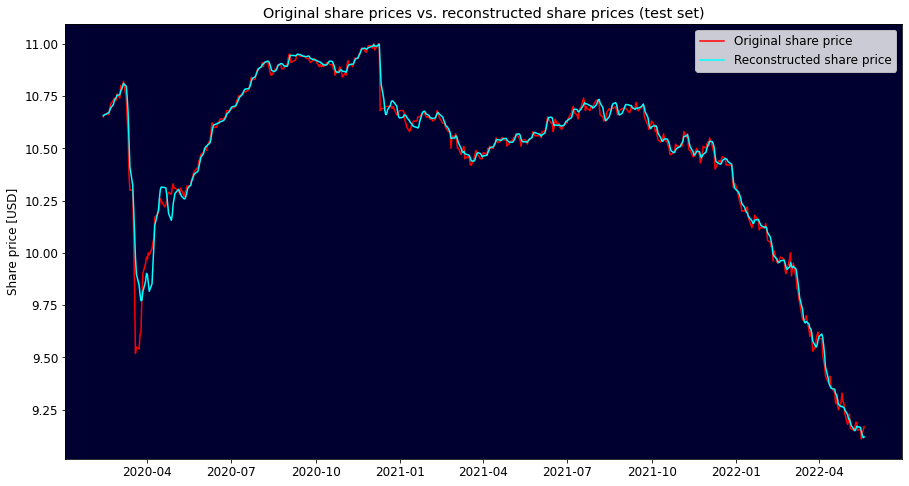

In [19]:
# Plot of original share prices vs. reconstructed share prices for the test set

_, p_test = plt.subplots(figsize=(15,8))

p_test.plot(test_dates, test_original, color='r', label='Original share price')
p_test.plot(test_dates, test_reconstructed, color='cyan', label='Reconstructed share price')

# Parameters of the plot

p_test.set_title('Original share prices vs. reconstructed share prices (test set)', size='x-large')
p_test.set_ylabel('Share price [USD]', size='large')
p_test.set_facecolor('#000030')
p_test.legend(fontsize='large')

plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.show()

# Anomalies
In this final part, we locate the anomalies in the test data using the reconstructions of the training data and test data generated by the autoencoder. We start by plotting the mean absolute error between the training data (resp. test data) and its reconstruction.

The mean absolute error consists in the element-wise absolute value of the array [original data - reconstruction], and then the average for each sample of size "timesteps" included in the resulting array.

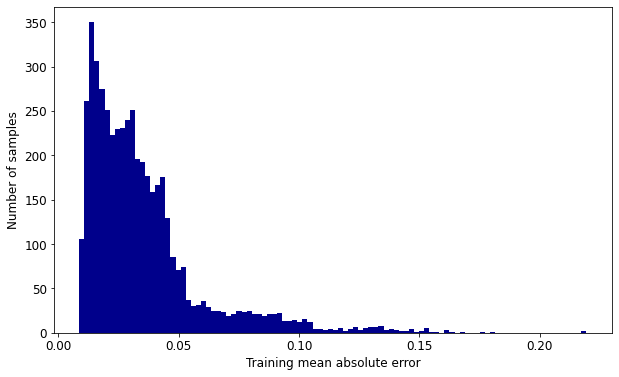

In [20]:
# Storing in "train_mae" the mean absolute error between "train_seqs" and its reconstruction

train_mae = np.mean(np.abs(train_seqs - model.predict(train_seqs)), axis=1)

# Histogram plot of the mean absolute error for the training data

plt.figure(figsize=(10,6))
plt.hist(train_mae, color='darkblue', bins=100)

# Parameters of the plot

plt.xlabel('Training mean absolute error', size='large')
plt.ylabel('Number of samples', size='large')
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.show()

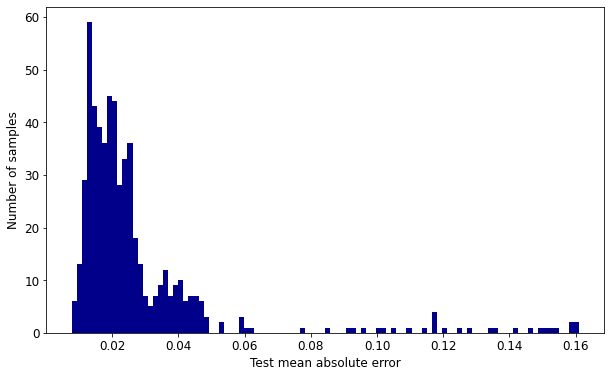

In [21]:
# Storing in "test_mae" the mean absolute error between "test_seqs" and its reconstruction

test_mae = np.mean(np.abs(test_seqs - model.predict(test_seqs)), axis=1)

# Histogram plot of the mean absolute error for the test data

plt.figure(figsize=(10,6))
plt.hist(test_mae, color='darkblue', bins=100)

# Parameters of the plot

plt.xlabel('Test mean absolute error', size='large')
plt.ylabel('Number of samples', size='large')
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.show()

Anomalies in the test data are defined as values far from the corresponding reconstructed values. The precise definition of "far" is somewhat arbitrary and can be adjusted. But, if both the training and test mean absolute errors "train_mae" and "test_mae" were normally distributed, then a reasonable threshold for the "far" value would be between 1 and 3 standard deviations from the mean value of "train_mae".

Under these assumptions, points in the test data whose distance from their reconstruction is larger than the mean of "train_mae" + 2 standard deviations of "train_mae" would only represent 5% of the test data, and thus could be considered as  "anomalies". See:<br>
https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule

We follow this heuristics, and thus define the threshold value accordingly.

In [22]:
threshold = np.mean(train_mae) + 2 * np.std(train_mae)

The next figure shows the dates at which the mean absolute error of the test data is larger than the threshold value.

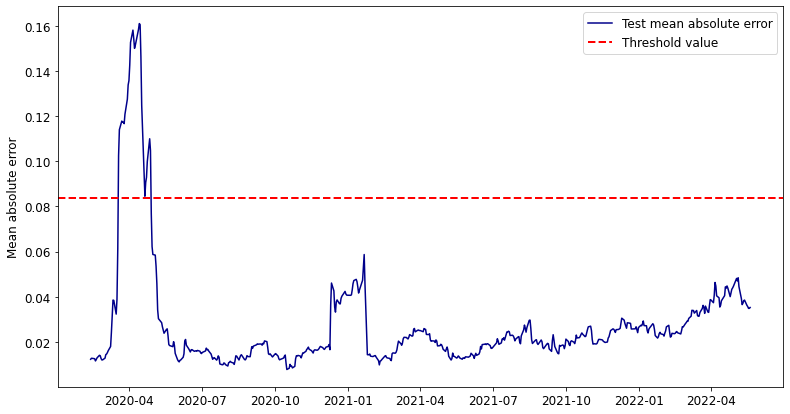

In [28]:
# Plot of the mean absolute error for the test data and the threshold value

_, p_threshold = plt.subplots(figsize=(13,7))
p_threshold.plot(test_dates, test_mae, color='darkblue', label='Test mean absolute error')
p_threshold.axhline(threshold, color='r', linestyle='--', linewidth=2, label='Threshold value')

# Parameters of the plot

plt.ylabel('Mean absolute error', size='large')
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.legend(fontsize='large')
plt.show()

Anomalies are points (values and dates) in the test data for which the mean absolute error of the test data is larger than the threshold value.

In [24]:
anomaly_values = test_original[test_mae >= threshold]
anomaly_dates = (test_dates.reshape(-1, 1))[test_mae >= threshold]

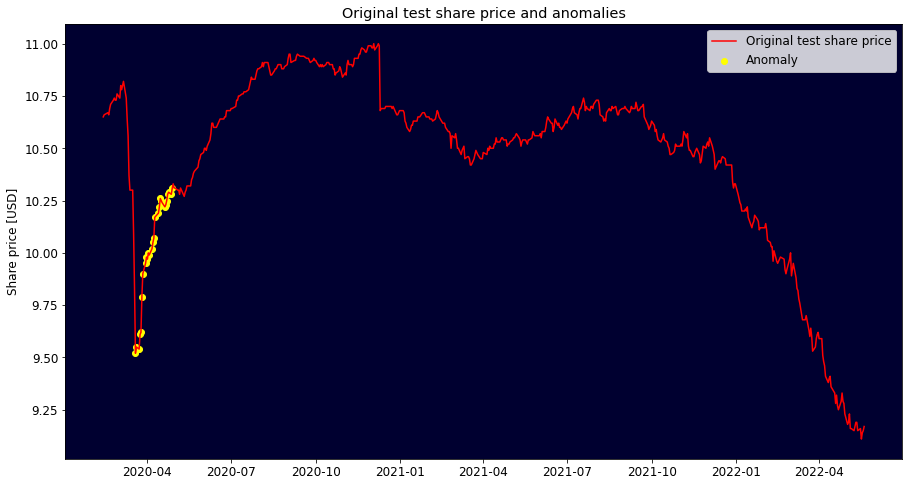

In [25]:
# Plot of original share prices and anomalies for the test set

_, p_anomal = plt.subplots(figsize=(15,8))

p_anomal.plot(test_dates, test_original, color='r', label='Original test share price')
p_anomal.scatter(anomaly_dates, anomaly_values, color='yellow',  marker='o', label='Anomaly')

# Parameters of the plot

p_anomal.set_title('Original test share price and anomalies', size='x-large')
p_anomal.set_ylabel('Share price [USD]', size='large')
p_anomal.set_facecolor('#000030')
p_anomal.legend(fontsize='large')

plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.show()